
# KD-Tree vs Radix-Tree Benchmark (JIT)

This notebook compares **KD-tree** and **Radix-tree** timing in three buckets:

1. `build`
2. `traversal`
3. `end-to-end` (`build + traversal`)

## Important comparability note

Traversal workloads are not mathematically identical:

- **KD-tree traversal**: kNN query (`query_neighbors`, `backend="tree"`)
- **Radix-tree traversal**: dual-tree interaction + neighbor-list construction
  (`compute_tree_geometry` + `build_interactions_and_neighbors`)

So treat this as a practical pipeline timing comparison, not exact algorithmic parity.

## JIT note

- KD build/traversal/e2e paths are JIT-wrapped in this notebook.
- Radix build uses `build_tree_jit`, but Radix traversal/e2e are run eagerly to
  avoid current tracer-bool limitations in `compute_tree_geometry` under outer `jax.jit`.


In [1]:

import time
from dataclasses import dataclass

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from yggdrax import (
    DualTreeTraversalConfig,
    build_interactions_and_neighbors,
    build_kdtree,
    build_tree,
    compute_tree_geometry,
)

print('jax:', jax.__version__)
print('device:', jax.devices()[0])


jax: 0.7.2
device: TFRT_CPU_0


In [2]:
@dataclass
class BenchConfig:
    n_points: int = 50_000
    dim: int = 3
    leaf_size_radix: int = 32
    leaf_size_kd: int = 32
    theta: float = 0.6
    repeats: int = 5
def make_problem(cfg: BenchConfig, seed: int = 0):
    key = jax.random.PRNGKey(seed)
    key_pos, key_mass = jax.random.split(key, 2)
    positions = jax.random.uniform(
        key_pos, (cfg.n_points, cfg.dim), minval=-1.0, maxval=1.0, dtype=jnp.float32
    )
    masses = jax.random.uniform(
        key_mass, (cfg.n_points,), minval=0.5, maxval=1.5, dtype=jnp.float32
    )
    return positions, masses
def block_tree_output(x):
    if isinstance(x, tuple):
        jax.tree_util.tree_map(jax.block_until_ready, x)
    else:
        jax.block_until_ready(x)
def timed_call(fn, *args, repeats=5):
    # warmup / compile
    out = fn(*args)
    block_tree_output(out)
    ms = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        out = fn(*args)
        block_tree_output(out)
        t1 = time.perf_counter()
        ms.append((t1 - t0) * 1e3)
    return out, jnp.asarray(ms)


In [3]:
def run_benchmark(cfg: BenchConfig, seed: int = 0):
    positions, masses = make_problem(cfg, seed=seed)
    traversal_cfg = DualTreeTraversalConfig(
        max_pair_queue=32768,
        process_block=256,
        max_interactions_per_node=4096,
        max_neighbors_per_leaf=4096,
    )
    # Build kernels (explicit jax.jit for both backends)
    radix_build = jax.jit(
        lambda p, m: build_tree(
            p,
            m,
            leaf_size=cfg.leaf_size_radix,
            return_reordered=True,
        )
    )
    kd_build = jax.jit(lambda p: build_kdtree(p, leaf_size=cfg.leaf_size_kd))
    # Build timing
    (radix_tree, radix_pos_sorted, _, _), t_radix_build = timed_call(
        radix_build, positions, masses, repeats=cfg.repeats
    )
    kd_tree, t_kd_build = timed_call(kd_build, positions, repeats=cfg.repeats)
    kd_pos_sorted = positions[kd_tree.particle_indices]
    # Traversal kernels (build excluded)
    radix_traversal = jax.jit(
        lambda t, ps: build_interactions_and_neighbors(
            t,
            compute_tree_geometry(t, ps),
            theta=cfg.theta,
            mac_type='dehnen',
            traversal_config=traversal_cfg,
        )
    )
    kd_traversal = jax.jit(
        lambda t, ps: build_interactions_and_neighbors(
            t,
            compute_tree_geometry(t, ps),
            theta=cfg.theta,
            mac_type='dehnen',
            traversal_config=traversal_cfg,
        )
    )
    _, t_radix_traversal = timed_call(
        radix_traversal,
        radix_tree,
        radix_pos_sorted,
        repeats=cfg.repeats,
    )
    _, t_kd_traversal = timed_call(
        kd_traversal,
        kd_tree,
        kd_pos_sorted,
        repeats=cfg.repeats,
    )
    # End-to-end kernels (build + traversal)
    radix_e2e = jax.jit(
        lambda p, m: (
            lambda t, ps: build_interactions_and_neighbors(
                t,
                compute_tree_geometry(t, ps),
                theta=cfg.theta,
                mac_type='dehnen',
                traversal_config=traversal_cfg,
            )
        )(*build_tree(p, m, leaf_size=cfg.leaf_size_radix, return_reordered=True)[:2])
    )
    kd_e2e = jax.jit(
        lambda p: (
            lambda t, ps: build_interactions_and_neighbors(
                t,
                compute_tree_geometry(t, ps),
                theta=cfg.theta,
                mac_type='dehnen',
                traversal_config=traversal_cfg,
            )
        )(*(lambda t: (t, p[t.particle_indices]))(build_kdtree(p, leaf_size=cfg.leaf_size_kd)))
    )
    _, t_radix_e2e = timed_call(radix_e2e, positions, masses, repeats=cfg.repeats)
    _, t_kd_e2e = timed_call(kd_e2e, positions, repeats=cfg.repeats)
    return {
        'radix_build_ms': t_radix_build,
        'kd_build_ms': t_kd_build,
        'radix_traversal_ms': t_radix_traversal,
        'kd_traversal_ms': t_kd_traversal,
        'radix_e2e_ms': t_radix_e2e,
        'kd_e2e_ms': t_kd_e2e,
    }


In [4]:
cfg = BenchConfig(
    n_points=30_000,
    dim=3,
    leaf_size_radix=32,
    leaf_size_kd=32,
    theta=0.6,
    repeats=5,
)
stats = run_benchmark(cfg, seed=0)
for k, v in stats.items():
    print(f"{k:>20}: mean={float(jnp.mean(v)):.2f} ms | std={float(jnp.std(v)):.2f} ms | runs={list(map(float, v))}")


      radix_build_ms: mean=8.57 ms | std=0.13 ms | runs=[8.691917057149112, 8.367625065147877, 8.509458042681217, 8.51883296854794, 8.740457938984036]
         kd_build_ms: mean=110.60 ms | std=1.00 ms | runs=[111.24666698742658, 109.80787500739098, 112.26395901758224, 109.66095793992281, 110.0282499101013]
  radix_traversal_ms: mean=236.96 ms | std=8.98 ms | runs=[254.8488749889657, 233.36233396548778, 233.4552080137655, 231.4475839957595, 231.68337508104742]
     kd_traversal_ms: mean=204.58 ms | std=5.08 ms | runs=[214.49412510264665, 203.0856249621138, 201.59391593188047, 200.33783302642405, 203.39816610794514]
        radix_e2e_ms: mean=244.80 ms | std=4.65 ms | runs=[246.3114580605179, 244.1311669535935, 237.46683297213167, 244.13245893083513, 251.94345810450613]
           kd_e2e_ms: mean=281.53 ms | std=4.19 ms | runs=[289.80874991975725, 278.4703749930486, 279.433291987516, 279.3484589783475, 280.5699589662254]


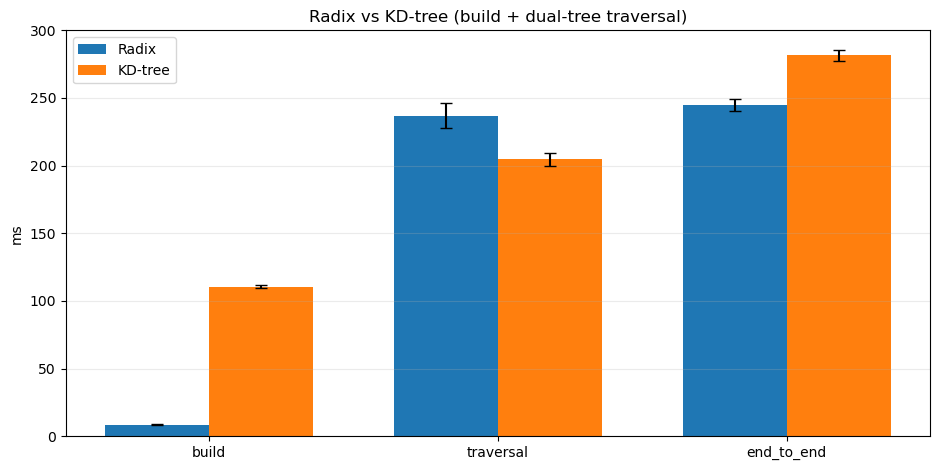

In [5]:
metrics = ['build', 'traversal', 'end_to_end']
radix_means = [
    float(jnp.mean(stats['radix_build_ms'])),
    float(jnp.mean(stats['radix_traversal_ms'])),
    float(jnp.mean(stats['radix_e2e_ms'])),
]
kd_means = [
    float(jnp.mean(stats['kd_build_ms'])),
    float(jnp.mean(stats['kd_traversal_ms'])),
    float(jnp.mean(stats['kd_e2e_ms'])),
]
radix_stds = [
    float(jnp.std(stats['radix_build_ms'])),
    float(jnp.std(stats['radix_traversal_ms'])),
    float(jnp.std(stats['radix_e2e_ms'])),
]
kd_stds = [
    float(jnp.std(stats['kd_build_ms'])),
    float(jnp.std(stats['kd_traversal_ms'])),
    float(jnp.std(stats['kd_e2e_ms'])),
]

x = jnp.arange(len(metrics))
width = 0.36

fig, ax = plt.subplots(figsize=(9.5, 4.8))
ax.bar(x - width / 2, radix_means, width, yerr=radix_stds, capsize=4, label='Radix')
ax.bar(x + width / 2, kd_means, width, yerr=kd_stds, capsize=4, label='KD-tree')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('ms')
ax.set_title('Radix vs KD-tree (build + dual-tree traversal)')
ax.grid(axis='y', alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()



## Interpretation tips

- `build`: tree construction cost only.
- `traversal`: operation cost with prebuilt tree.
- `end_to_end`: what one full step costs in a rebuild-each-step workflow.

If your use case rebuilds every optimization step, `end_to_end` usually matters most.


In [6]:
# KD-tree leaf-size sweep (build_interactions_and_neighbors)
leaf_sizes = [4, 8, 16, 32, 64]
leaf_sweep = {}

for leaf in leaf_sizes:
    cfg_leaf = BenchConfig(
        n_points=cfg.n_points,
        dim=cfg.dim,
        leaf_size_radix=cfg.leaf_size_radix,
        leaf_size_kd=leaf,
        theta=cfg.theta,
        repeats=max(3, cfg.repeats),
    )
    stats_leaf = run_benchmark(cfg_leaf, seed=0)
    leaf_sweep[leaf] = {
        'kd_build_ms': float(jnp.mean(stats_leaf['kd_build_ms'])),
        'kd_traversal_ms': float(jnp.mean(stats_leaf['kd_traversal_ms'])),
        'kd_e2e_ms': float(jnp.mean(stats_leaf['kd_e2e_ms'])),
    }

print('KD-tree leaf-size sweep (means in ms):')
for leaf in leaf_sizes:
    s = leaf_sweep[leaf]
    print(f"leaf_size={leaf:>2} | build={s['kd_build_ms']:.2f} | traversal={s['kd_traversal_ms']:.2f} | end_to_end={s['kd_e2e_ms']:.2f}")

x = jnp.arange(len(leaf_sizes))
build_vals = [leaf_sweep[l]['kd_build_ms'] for l in leaf_sizes]
traversal_vals = [leaf_sweep[l]['kd_traversal_ms'] for l in leaf_sizes]
e2e_vals = [leaf_sweep[l]['kd_e2e_ms'] for l in leaf_sizes]

fig, ax = plt.subplots(figsize=(9.5, 4.8))
ax.plot(x, build_vals, marker='o', label='KD build')
ax.plot(x, traversal_vals, marker='o', label='KD traversal')
ax.plot(x, e2e_vals, marker='o', label='KD end-to-end')
ax.set_xticks(x)
ax.set_xticklabels([str(v) for v in leaf_sizes])
ax.set_xlabel('KD leaf_size')
ax.set_ylabel('ms')
ax.set_title('KD-tree performance vs leaf_size (dual-tree traversal)')
ax.grid(alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()


KeyboardInterrupt: 